## Motion Correction 

Motion correction run on sample videos


In [40]:
from builtins import zip
from builtins import str
from builtins import map
from builtins import range
from past.utils import old_div

import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import psutil
import scipy
from skimage.external.tifffile import TiffFile
import sys
import time
import logging

try:
    cv2.setNumThreads(0)
except:
    pass

try:
    if __IPYTHON__:
        get_ipython().magic('load_ext autoreload')
        get_ipython().magic('autoreload 2')
except NameError:
    pass

logging.basicConfig(format=
                          "%(relativeCreated)12d [%(filename)s:%(funcName)20s():%(lineno)s] [%(process)d] %(message)s",
                    level=logging.INFO)

import caiman as cm
from caiman.motion_correction import MotionCorrect, tile_and_correct, motion_correction_piecewise
from caiman.utils.utils import download_demo

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


List files for motion correction

In [41]:
#vid_dir = '/home/prez/neurodata/cheeseboard-down/down_2/2020-10/habituation/2020_10_08/trial/N-BL/Session1/14_16_09/Miniscope/'
vid_dir = '/mnt/DATA/Su_data/drive-download-20210317T170048Z-001/'
fnames = ['msCam1.avi', 'msCam2.avi', 'msCam3.avi', 'msCam4.avi']
fpaths = [vid_dir + f for f in fnames]

Remove noise

In [42]:
import downsample
import remove_noise

crop_and_downsample = True
# Set to None if specified for the animal in csv file
crop_roi = (1, 752, 1, 480)
rotation = 0
#animal_name = 'R-TR'
spatial_downsample = 2
apply_noise_removal = False

if crop_and_downsample:
    if crop_roi is None:
        crop_roi, rotation = downsample.get_roi_xy(
            '/home/prez/neurodata/cheeseboard/2020-10/test_session/rois.csv',
            animal_name)
    fpaths = [downsample.crop_and_downsample(video, crop_roi, rotation,
                                             spatial_downsample, replace_video=False) 
              for video in fpaths]

if apply_noise_removal:
    maskFFT = remove_noise.create_FFT_Mask(fpaths)
    meanFrame = remove_noise.calc_mean_frame_vals(fpaths)
    meanFrameFiltered = remove_noise.lowpass_filter_vals(meanFrame)
    remove_noise.denoise_vids(fpaths, maskFFT, meanFrameFiltered, replace_vid=False, output_dir='denoised')
    fpaths = [os.path.dirname(fpaths[0]) + '/denoised/' + f for f in fnames]

     4308810 [downsample.py: crop_and_downsample():38] [6846] Downsampling and cropping file: /mnt/DATA/Su_data/drive-download-20210317T170048Z-001/msCam1.avi
     4308841 [downsample.py: crop_and_downsample():43] [6846] Cropped and resized output video shape: (375, 239)
     4310776 [downsample.py: crop_and_downsample():38] [6846] Downsampling and cropping file: /mnt/DATA/Su_data/drive-download-20210317T170048Z-001/msCam2.avi
     4310788 [downsample.py: crop_and_downsample():43] [6846] Cropped and resized output video shape: (375, 239)
     4314326 [downsample.py: crop_and_downsample():38] [6846] Downsampling and cropping file: /mnt/DATA/Su_data/drive-download-20210317T170048Z-001/msCam3.avi
     4314329 [downsample.py: crop_and_downsample():43] [6846] Cropped and resized output video shape: (375, 239)
     4317873 [downsample.py: crop_and_downsample():38] [6846] Downsampling and cropping file: /mnt/DATA/Su_data/drive-download-20210317T170048Z-001/msCam4.avi
     4317889 [downsample.

In [43]:
m_orig = cm.load_movie_chain(fpaths)

100%|██████████| 4/4 [00:01<00:00,  3.00it/s]


Uncomment to playback the video

In [44]:
downsample_ratio = .2  # motion can be perceived better when downsampling in time
m_orig.resize(1, 1, downsample_ratio).play(q_max=99.5, fr=20, magnification=1)   # play movie (press q to exit)

In [45]:
#%% start the cluster (if a cluster already exists terminate it)
if 'dview' in locals():
    cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

     4364325 [cluster.py:         stop_server():358] [6846] stop_cluster(): done


In [46]:
max_shifts = (8, 8)  # maximum allowed rigid shift in pixels (view the movie to get a sense of motion)
strides =  (48, 48)  # create a new patch every x pixels for pw-rigid correction
overlaps = (16, 16)  # overlap between pathes (size of patch strides+overlaps)
num_frames_split = 100  # length in frames of each chunk of the movie (to be processed in parallel)
max_deviation_rigid = 3   # maximum deviation allowed for patch with respect to rigid shifts
pw_rigid = False  # flag for performing rigid or piecewise rigid motion correction
shifts_opencv = True  # flag for correcting motion using bicubic interpolation (otherwise FFT interpolation is used)
border_nan = 'copy'  # replicate values along the boundary (if True, fill in with NaN)
gSig_filt = 9

In [47]:
from caiman.motion_correction import motion_correct_oneP_rigid, motion_correct_oneP_nonrigid     
mc = motion_correct_oneP_rigid(fpaths,                                  
                               gSig_filt=(gSig_filt, gSig_filt),                                                                                                                          
                               max_shifts=max_shifts,                       
                               dview=dview,               
                               splits_rig=2,                       
                               save_movie=True,                             
                               border_nan=border_nan)  
new_templ = mc.total_template_rig

     4366330 [movies.py:      extract_shifts():371] [6846] Movie average is negative. Removing 1st percentile.
     4366545 [movies.py:      extract_shifts():371] [6846] Movie average is negative. Removing 1st percentile.
     4366739 [movies.py:      extract_shifts():371] [6846] Movie average is negative. Removing 1st percentile.
     4367021 [motion_correction.py:motion_correction_piecewise():3017] [6846] Saving file as /mnt/DATA/Su_data/drive-download-20210317T170048Z-001/down/msCam1_rig__d1_238_d2_374_d3_1_order_F_frames_1000_.mmap
     4367030 [motion_correction.py:motion_correction_piecewise():3030] [6846] ** Starting parallel motion correction **
     4376693 [motion_correction.py:motion_correction_piecewise():3038] [6846] ** Finished parallel motion correction **
     4376795 [motion_correction.py:motion_correction_piecewise():3017] [6846] Saving file as /mnt/DATA/Su_data/drive-download-20210317T170048Z-001/down/msCam2_rig__d1_238_d2_374_d3_1_order_F_frames_1000_.mmap
     4376

100%|██████████| 4/4 [00:01<00:00,  2.54it/s]


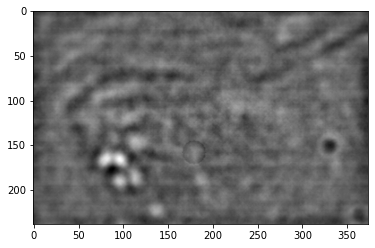

In [48]:
# load motion corrected movie
#m_rig = cm.load(mc.5map_file)
gSig_filt = 9
m_rig = cm.load(mc.fname_tot_rig)
bord_px_rig = np.ceil(np.max(mc.shifts_rig)).astype(np.int)
m_rig.shape
hpass_img = cm.motion_correction.high_pass_filter_space(m_rig[200,:,:], (gSig_filt,gSig_filt))
plt.imshow(hpass_img, cmap = 'gray')

In [49]:
#%% inspect movie
#m_rig.resize(1, 1, downsample_ratio).play(
#    q_max=99.5, fr=20, magnification=2, bord_px = 0*bord_px_rig) # press q to exit

plot the shifts computed by rigid registration

Text(0, 0.5, 'pixels')

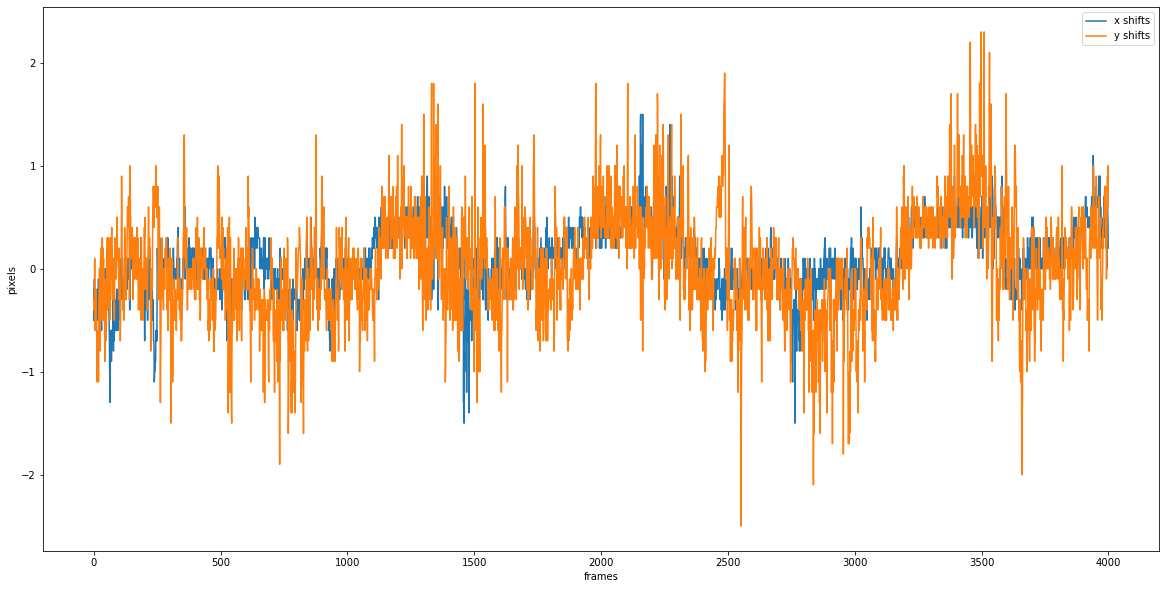

In [50]:
#%% plot rigid shifts
plt.close()
plt.figure(figsize = (20,10))
plt.plot(mc.shifts_rig)
plt.legend(['x shifts','y shifts'])
plt.xlabel('frames')
plt.ylabel('pixels')

## Piecewise rigid registration
While rigid registration corrected for a lot of the movement, there is still non-uniform motion present in the registered file. To correct for that we can use piece-wise rigid registration **directly in the original file** by setting `mc.pw_rigid=True`. As before the registered file is saved in a memory mapped format in the location given by `mc.mmap_file`.

In [51]:
%%capture
#%% motion correct piecewise rigid
#mc.pw_rigid = True  # turn the flag to True for pw-rigid motion correction
#mc.template = mc.mmap_file  # use the template obtained before to save in computation (optional)

#mc.motion_correct(save_movie=True, template=mc.total_template_rig)
mc.motion_correct_pwrigid(save_movie=True, template=new_templ)
#mc = motion_correct_oneP_nonrigid(                                                                                                                                       
#    fpaths,                                                         
#    gSig_filt=gSig_filt,                                                
#    max_shifts=max_shifts,                                              
#    strides=strides,                                                    
#    overlaps=overlaps,                                                  
#    splits_els=2,                                              
#    upsample_factor_grid=4,                          
#    max_deviation_rigid=max_deviation_rigid,                            
#    dview=dview,                                                        
#    splits_rig=None,                                                    
#    save_movie=True,                                                    
#    new_templ=new_templ,  # template to initialize motion correction
#    border_nan='copy'                                                   
#)

m_els = cm.load(mc.fname_tot_els)
#m_els.resize(1, 1, downsample_ratio).play(
#    q_max=99.5, fr=30, magnification=2,bord_px = bord_px_rig)

     4410100 [motion_correction.py:motion_correction_piecewise():3017] [6846] Saving file as /mnt/DATA/Su_data/drive-download-20210317T170048Z-001/down/msCam1_els__d1_238_d2_374_d3_1_order_F_frames_1000_.mmap
     4410102 [motion_correction.py:motion_correction_piecewise():3030] [6846] ** Starting parallel motion correction **
     4422707 [motion_correction.py:motion_correction_piecewise():3038] [6846] ** Finished parallel motion correction **
     4422800 [motion_correction.py:motion_correction_piecewise():3017] [6846] Saving file as /mnt/DATA/Su_data/drive-download-20210317T170048Z-001/down/msCam2_els__d1_238_d2_374_d3_1_order_F_frames_1000_.mmap
     4422802 [motion_correction.py:motion_correction_piecewise():3030] [6846] ** Starting parallel motion correction **
     4444146 [motion_correction.py:motion_correction_piecewise():3038] [6846] ** Finished parallel motion correction **
     4444246 [motion_correction.py:motion_correction_piecewise():3017] [6846] Saving file as /mnt/DATA

Now concatenate all the movies (raw, rigid, and pw-rigid) for inspection

In [52]:
cm.concatenate([m_orig.resize(1, 1, downsample_ratio) - mc.min_mov*mc.nonneg_movie,
                m_rig.resize(1, 1, downsample_ratio), m_els.resize(
            1, 1, downsample_ratio)], axis=2).play(fr=20, q_max=99.5, magnification=2, bord_px=bord_px_rig)

In [53]:
#m_els.save('/tmp/1.avi')

From the movie we can see that pw-rigid registration corrected for the non uniform motion of the data. This was done by estimating different displacement vectors for the different patches in the FOV. This can be visualized by plotting all the computed shifts were a dispersion in the shifts in the y direction is apparent. In this case, the shifts along the two axes are stored in `mc.x_shifts_els` and `mc.y_shifts_els`, respectively.

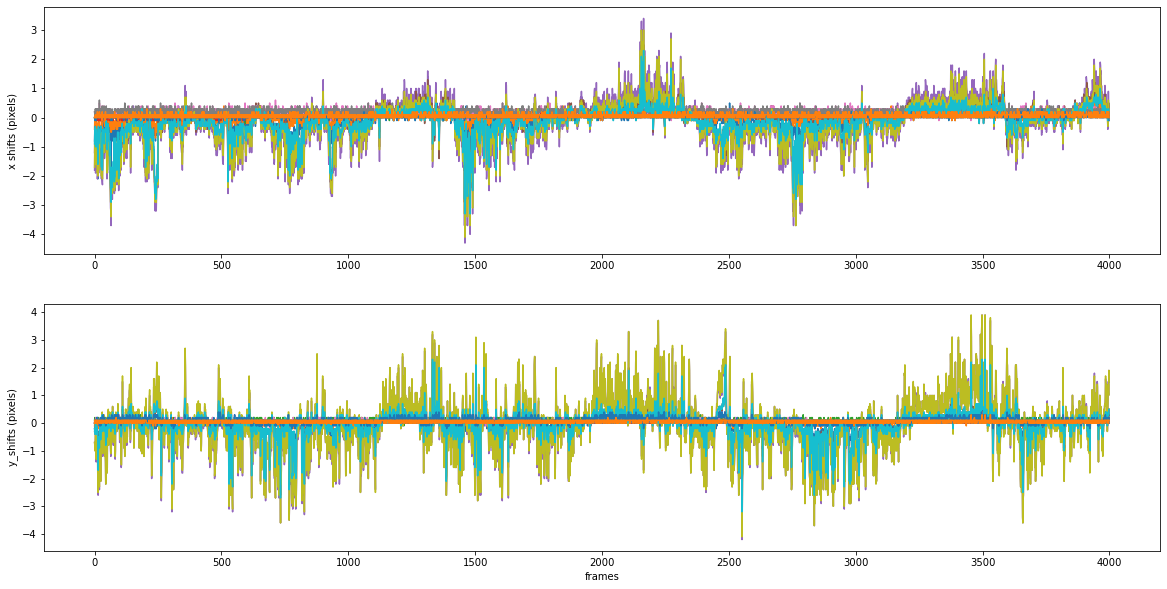

In [54]:
#%% visualize elastic shifts
plt.close()
plt.figure(figsize = (20,10))
plt.subplot(2, 1, 1)
plt.plot(mc.x_shifts_els)
plt.ylabel('x shifts (pixels)')
plt.subplot(2, 1, 2)
plt.plot(mc.y_shifts_els)
plt.ylabel('y_shifts (pixels)')
plt.xlabel('frames')
#%% compute borders to exclude
bord_px_els = np.ceil(np.maximum(np.max(np.abs(mc.x_shifts_els)),
                                 np.max(np.abs(mc.y_shifts_els)))).astype(np.int)

The improvement in performance can also be seen by a more crisp summary statistic image. Below we plot the correlation images for the three datasets.

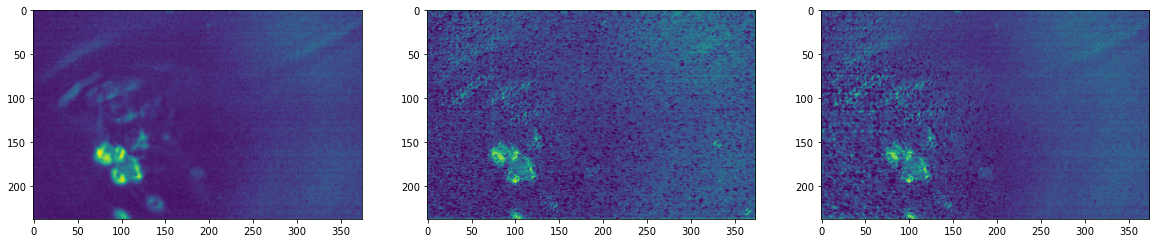

In [55]:
plt.figure(figsize = (20,10))
plt.subplot(1,3,1); plt.imshow(m_orig.local_correlations(eight_neighbours=True, swap_dim=False))
plt.subplot(1,3,2); plt.imshow(m_rig.local_correlations(eight_neighbours=True, swap_dim=False))
plt.subplot(1,3,3); plt.imshow(m_els.local_correlations(eight_neighbours=True, swap_dim=False))

In [56]:
cm.stop_server(dview=dview) # stop the server

     4510674 [cluster.py:         stop_server():358] [6846] stop_cluster(): done


## Quality assessment 

Apart from inspection, the performance of the registration methods can be quantified using several measures. Below we compute measures such as correlation of each frame with mean, crispness of summary image, and residual optical flow for all three cases. For more info see [[1]](#normcorre). Note that computation of the residual optical flow can be computationally intensive.

In [57]:
%%capture
#% compute metrics for the results (TAKES TIME!!)
final_size = np.subtract(mc.total_template_els.shape, 2 * bord_px_els) # remove pixels in the boundaries
winsize = 100
swap_dim = False
resize_fact_flow = .2    # downsample for computing ROF

tmpl_rig, correlations_orig, flows_orig, norms_orig, crispness_orig = cm.motion_correction.compute_metrics_motion_correction(
    fpaths[0], final_size[0], final_size[1], swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)

tmpl_rig, correlations_rig, flows_rig, norms_rig, crispness_rig = cm.motion_correction.compute_metrics_motion_correction(
    mc.fname_tot_rig[0], final_size[0], final_size[1],
    swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)

tmpl_els, correlations_els, flows_els, norms_els, crispness_els = cm.motion_correction.compute_metrics_motion_correction(
    mc.fname_tot_els[0], final_size[0], final_size[1],
    swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)

     4511094 [motion_correction.py:compute_metrics_motion_correction():2526] [6846] [5, -5, 5, -5]
     4514122 [motion_correction.py:compute_metrics_motion_correction():2558] [6846] Compute optical flow .. 
     4526715 [motion_correction.py:compute_metrics_motion_correction():2526] [6846] [5, -5, 5, -5]
     4529700 [motion_correction.py:compute_metrics_motion_correction():2558] [6846] Compute optical flow .. 
     4541640 [motion_correction.py:compute_metrics_motion_correction():2526] [6846] [5, -5, 5, -5]
     4544590 [motion_correction.py:compute_metrics_motion_correction():2558] [6846] Compute optical flow .. 


Plot correlation with mean frame for each dataset

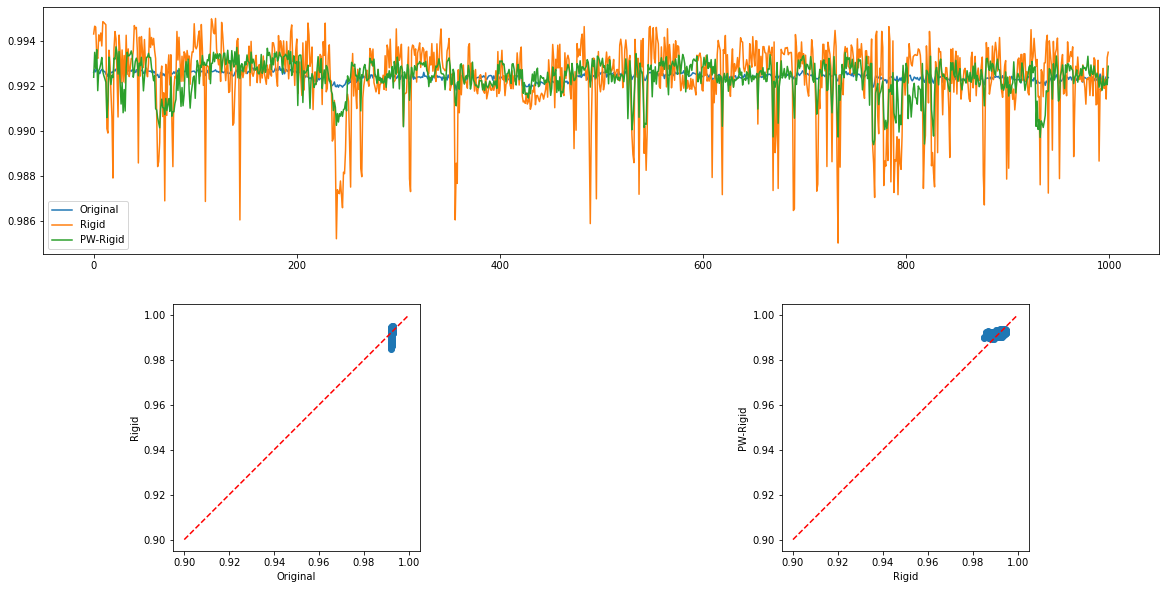

In [58]:
plt.figure(figsize = (20,10))
plt.subplot(211); plt.plot(correlations_orig); plt.plot(correlations_rig); plt.plot(correlations_els)
plt.legend(['Original','Rigid','PW-Rigid'])
plt.subplot(223); plt.scatter(correlations_orig, correlations_rig); plt.xlabel('Original'); 
plt.ylabel('Rigid'); plt.plot([0.9,1.0],[0.9,1.0],'r--')
axes = plt.gca(); axes.set_xlim([0.9,1.0]); axes.set_ylim([0.9,1.0]); plt.axis('square');
plt.subplot(224); plt.scatter(correlations_rig, correlations_els); plt.xlabel('Rigid'); 
plt.ylabel('PW-Rigid'); plt.plot([0.9,1.0],[0.9, 1.0],'r--')
axes = plt.gca(); axes.set_xlim([0.9,1.0]); axes.set_ylim([0.9,1.0]); plt.axis('square');


In [59]:
# print crispness values
print('Crispness original: '+ str(int(crispness_orig)))
print('Crispness rigid: '+ str(int(crispness_rig)))
print('Crispness elastic: '+ str(int(crispness_els)))

Crispness original: 390
Crispness rigid: 289
Crispness elastic: 327


KeysView(<numpy.lib.npyio.NpzFile object at 0x7f9d4d990950>)
/mnt/DATA/Su_data/drive-download-20210317T170048Z-001/down/msCam1_els__d1_238_d2_374_d3_1_order_F_frames_1000_._metrics.npz
43.1087+/-22.382355 ; 327.78143 ; 9.319608302101667
KeysView(<numpy.lib.npyio.NpzFile object at 0x7f9d4d949990>)
/mnt/DATA/Su_data/drive-download-20210317T170048Z-001/down/msCam1_rig__d1_238_d2_374_d3_1_order_F_frames_1000_._metrics.npz
61.824696+/-32.04012 ; 289.73288 ; 12.534220638814757


     4558490 [movies.py:                load():1741] [6846] File request:[/mnt/DATA/Su_data/drive-download-20210317T170048Z-001/down/msCam1mmap] not found!


KeysView(<numpy.lib.npyio.NpzFile object at 0x7f9d4d9497d0>)
/mnt/DATA/Su_data/drive-download-20210317T170048Z-001/down/msCam1_metrics.npz
3.1225421+/-0.68404114 ; 390.94058 ; 4.5080663208602525


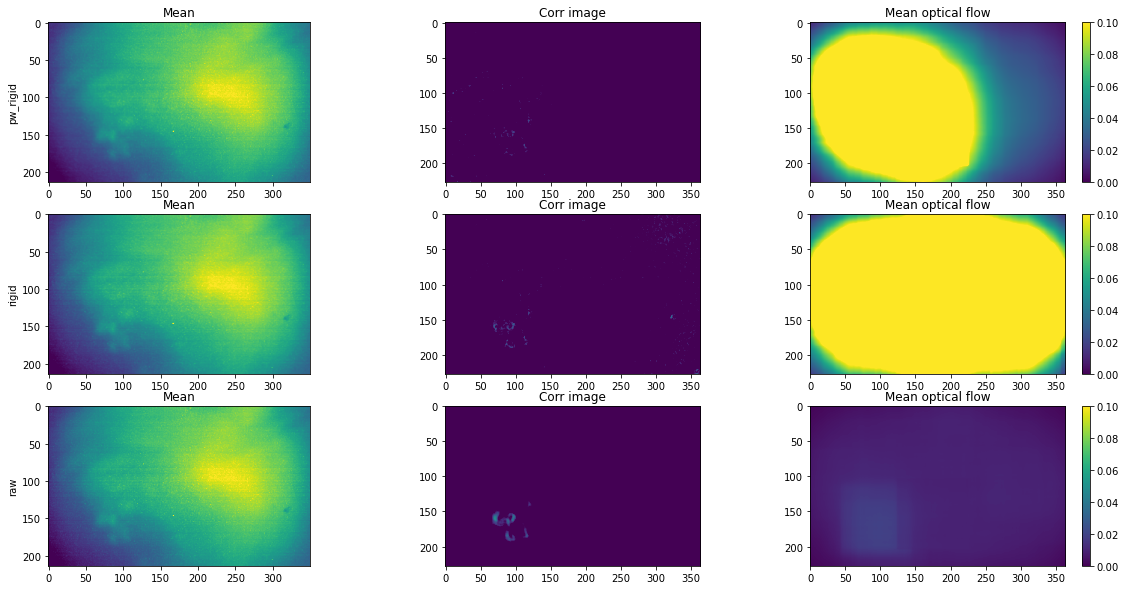

In [60]:
#%% plot the results of Residual Optical Flow
fls = [mc.fname_tot_els[0][:-4] + '_metrics.npz', mc.fname_tot_rig[0][:-4] +
       '_metrics.npz', mc.fname[0][:-4] + '_metrics.npz']

plt.figure(figsize = (20,10))
for cnt, fl, metr in zip(range(len(fls)),fls,['pw_rigid','rigid','raw']):
    with np.load(fl) as ld:
        print(ld.keys())
        print(fl)
        print(str(np.mean(ld['norms'])) + '+/-' + str(np.std(ld['norms'])) +
              ' ; ' + str(ld['smoothness']) + ' ; ' + str(ld['smoothness_corr']))
        
        plt.subplot(len(fls), 3, 1 + 3 * cnt)
        plt.ylabel(metr)
        try:
            mean_img = np.mean(
            cm.load(fl[:-12] + 'mmap'), 0)[12:-12, 12:-12]
        except:
            try:
                mean_img = np.mean(
                    cm.load(fl[:-12] + '.avi'), 0)[12:-12, 12:-12]
            except:
                mean_img = np.mean(
                    cm.load(fl[:-12] + 'hdf5'), 0)[12:-12, 12:-12]
                    
        lq, hq = np.nanpercentile(mean_img, [.5, 99.8])
        plt.imshow(mean_img, vmin=lq, vmax=hq)
        plt.title('Mean')
        plt.subplot(len(fls), 3, 3 * cnt + 2)
        plt.imshow(ld['img_corr'], vmin=0.2, vmax=.85)
        plt.title('Corr image')
        plt.subplot(len(fls), 3, 3 * cnt + 3)
        #plt.plot(ld['norms'])
        #plt.xlabel('frame')
        #plt.ylabel('norm opt flow')
        #plt.subplot(len(fls), 3, 3 * cnt + 3)
        flows = ld['flows']
        plt.imshow(np.mean(
        np.sqrt(flows[:, :, :, 0]**2 + flows[:, :, :, 1]**2), 0), vmin=0, vmax=0.1)
        plt.colorbar()
        plt.title('Mean optical flow')      